In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm





In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
train_file = np.load('/content/drive/MyDrive/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)

test_file = np.load('/content/drive/MyDrive/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


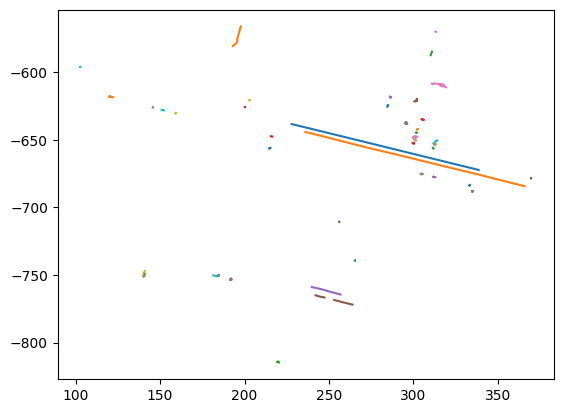

In [4]:
data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

In [5]:
# make gif out of a scene.
def make_gif(data_matrix, name='example'):
   cmap = plt.cm.get_cmap('viridis', 50)
   fig, ax = plt.subplots(figsize=(10, 10))
   # Function to update plot for each frame
   def update(frame):
       ax.clear()

       # Get data for current timestep
       for i in range(1, data_matrix.shape[0]):
           x = data_matrix[i, frame, 0]
           y = data_matrix[i, frame, 1]
           if x != 0 and y != 0:
               xs = data_matrix[i, :frame+1, 0]  # Include current frame
               ys = data_matrix[i, :frame+1, 1]  # Include current frame
               # trim all zeros
               mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
               xs = xs[mask]
               ys = ys[mask]

               # Only plot if we have points to plot
               if len(xs) > 0 and len(ys) > 0:
                   color = cmap(i)
                   ax.plot(xs, ys, alpha=0.9, color=color)
                   ax.scatter(x, y, s=80, color=color)

       ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
       ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1], s=80, color='tab:orange')
       # Set title with timestep
       ax.set_title(f'Timestep {frame}')
       # Set consistent axis limits
       ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
       ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
       ax.legend()

       return ax.collections + ax.lines

   # Create animation
   anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                               interval=100, blit=True)
   # Save as GIF
   anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
   plt.close()


In [6]:
make_gif(train_data[1], 'index0')

<ipython-input-5-8885094b5927>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 50)


In [7]:
# Split x and y for train data.
train_x, train_y = train_data[..., :50, :], train_data[:, 0, 50:, :2]

# get the average velocity of the prediction agent
velocity_diff = train_x[...,1:, :2] - train_x[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(10000, 50, 49, 2)
(10000, 2)


In [8]:
# create pred_y
train_pred_y = np.zeros((10000, 60, 2))
starting_point = train_x[:, 0, -1, :2] # shape (10000, 2)

for t in range(60):
    train_pred_y[:,t,:] = starting_point + (t+1) * constant_vel

In [9]:
# calculate train loss
mse = ((train_y - train_pred_y)**2).mean()
print(mse)

54.18623384395051


In [10]:
# prepare submission
# get the average velocity of the prediction agent
velocity_diff = test_data[...,1:, :2] - test_data[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(2100, 50, 49, 2)
(2100, 2)


In [11]:
# create pred_y for test set

test_pred_y = np.zeros((2100, 60, 2))
starting_point = test_data[:, 0, -1, :2]

for t in range(60):
    test_pred_y[:,t,:] = starting_point + (t+1) * constant_vel

In [12]:
# reshape to fit desired format: (2100, 60, 2) -> (12600, 2)
pred_output = test_pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('constant_vel_submission.csv')

In [13]:
train_x.shape

(10000, 50, 50, 6)

In [14]:
ego = train_x[:, 0, :, :]
ego.shape

(10000, 50, 6)

In [44]:
ego_pos = ego[:, :, :2]
print("ego pos shape:", ego_pos.shape)
ego_vel = ego[:, :, 2:4]
print("ego vel shape:", ego_vel.shape)
ego_heading = ego[:, :, 4]
print("ego heading shape:", ego_heading.shape)
ego_obj = ego[:, 0, 5].reshape(-1, 1)
print("ego obj type shape:", ego_obj.shape)

timestamps = np.arange(0, 50, 10, dtype = int).tolist() + [49]
ego_pos_10 = ego_pos[:, timestamps, :].reshape(train_x.shape[0], -1)
print("ego pos 10 shape:", ego_pos_10.shape)
ego_vel_10 = ego_vel[:, timestamps, :].reshape(train_x.shape[0], -1)
print("ego vel 10 shape:", ego_vel_10.shape)
ego_heading_10 = ego_heading[:, timestamps].reshape(train_x.shape[0], -1)
print("ego heading 10 shape:", ego_heading_10.shape)

timestamps_last_5 = np.arange(45, 50).tolist()
print(timestamps_last_5)
ego_pos_last_10 = ego_pos[:, timestamps_last_5, :].reshape(train_x.shape[0], -1)
print(ego_pos_last_10.shape)
ego_vel_last_10 = ego_vel[:, timestamps_last_5, :].reshape(train_x.shape[0], -1)
print(ego_vel_last_10.shape)
ego_heading_last_10 = ego_heading[:, timestamps_last_5].reshape(train_x.shape[0], -1)
print(ego_heading_last_10.shape)


ego_vel_reshape = ego_vel.reshape(train_x.shape[0], 10, 5, 2)
ego_avg_vel_5 = np.mean(ego_vel_reshape, axis = 2).reshape(train_x.shape[0], -1)
ego_avg_vel_5.shape

# calc overall average velocity and heading
ego_avg_vel = np.mean(ego_vel, axis = 1)
ego_avg_heading = np.mean(ego_heading, axis = 1).reshape(-1, 1)
ego_avg_heading.shape


ego pos shape: (10000, 50, 2)
ego vel shape: (10000, 50, 2)
ego heading shape: (10000, 50)
ego obj type shape: (10000, 1)
ego pos 10 shape: (10000, 12)
ego vel 10 shape: (10000, 12)
ego heading 10 shape: (10000, 6)
[45, 46, 47, 48, 49]
(10000, 10)
(10000, 10)
(10000, 5)


(10000, 1)

In [35]:
class LinearRegressionModel:
  def __init__(self):
    self.model = LinearRegression()

  def extract_features(self, X):
    # obtain the ego vehicle's data
    ego = X[:, 0, :, :] #(10000, 50, 6)

    # obtain ego vehicle positions, velocities, headings, and obj type
    ego_pos = ego[:, :, :2] #(10000, 50, 2)
    ego_vel = ego[:, :, 2:4] #(10000, 50, 2)
    ego_heading = ego[:, :, 4] #(10000, 50)
    ego_obj = ego[:, 0, 5].reshape(-1, 1) #(10000, 1)


    # timestamps = [0, 10, 20, 30, 40, -1]
    timestamps = np.arange(0, 50, 10, dtype = int).tolist() + [49]

    # obtain positions, velocities, and heading at every 5 timestamps, including final timestamp
    ego_pos_every_10 = ego_pos[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_vel_every_10 = ego_vel[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_heading_every_10 = ego_heading[:, timestamps].reshape(X.shape[0], -1) #(10000, 6)
    # ego_heading_every_10_sin = np.sin(ego_heading_every_10)
    # ego_heading_every_10_cos = np.cos(ego_heading_every_10)
    # ego_heading_every_10 = np.concatenate((ego_heading_every_10_sin, ego_heading_every_10_cos), axis = 1)

    # obtain pos, vel, and heading at last 5 timestamps
    timestamps_last_5 = np.arange(45, 50).tolist()
    ego_pos_last_10 = ego_pos[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_vel_last_10 = ego_vel[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_heading_last_10 = ego_heading[:, timestamps_last_5].reshape(X.shape[0], -1) #(10000, 5)
    # ego_heading_last_10_sin = np.sin(ego_heading_last_10)
    # ego_heading_last_10_cos = np.cos(ego_heading_last_10)
    # ego_heading_last_10 = np.concatenate((ego_heading_last_10_sin, ego_heading_last_10_cos), axis = 1)

    # calc average velocity and heading between timestamps (every 10 seconds)
    ego_vel_reshape = ego_vel.reshape(X.shape[0], 5, 10, 2)
    ego_avg_vel_every_10 = np.mean(ego_vel_reshape, axis = 2).reshape(X.shape[0], -1)
    ego_heading_reshape = ego_heading.reshape(X.shape[0], 5, 10)
    ego_avg_heading_every_10 = np.mean(ego_heading_reshape, axis = 2).reshape(X.shape[0], -1)
    # ego_avg_heading_every_10_sin = np.mean(np.sin(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10_cos = np.mean(np.cos(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10 = np.concatenate((ego_avg_heading_every_10_sin, ego_avg_heading_every_10_cos), axis = 1)


    # calc overall average velocity and heading
    ego_avg_vel = np.mean(ego_vel, axis = 1)
    ego_avg_heading = np.mean(ego_heading, axis = 1).reshape(-1, 1)
    # ego_avg_heading_sin = np.mean(np.sin(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading_cos = np.mean(np.cos(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading = np.concatenate((ego_avg_heading_sin, ego_avg_heading_cos), axis = 1)


    # calc acceleration at timestamps
    acc_5 = []
    for t in timestamps[1:]:
      acc = ego_vel[:, t, :] - ego_vel[:, t-1, :] #(10000, 2)
      acc_5.append(acc)
    ego_acc = np.concatenate(acc_5, axis=1)

    # calc distance from 5 closest agents at timestamps
    other_pos = X[:, 1:, :, :2]
    min_distances = []

    for t in timestamps:
      ego_pos_t = ego_pos[:, t, :] #(10000, 2)
      other_pos_t = other_pos[:, :, t, :] #(10000, 49, 2)

      distances = np.linalg.norm(ego_pos_t[:, np.newaxis, :] - other_pos_t, axis = -1) #(10000, 49)
      distances_sorted = np.sort(distances, axis = 1) #(10000, 49)
      min_distances_5 = distances_sorted[:, :5] #(10000, 5)
      min_distances.append(min_distances_5)

    ego_min_dist = np.concatenate(min_distances, axis = 1)

    # calc total distance traveled
    ego_pos_change = ego_pos[:, 1:, :] - ego_pos[:, :-1, :] #(10000, 49, 2)
    ego_distance_traveled = np.linalg.norm(ego_pos_change, axis = -1) #(10000, 49)
    ego_total_distance = np.sum(ego_distance_traveled, axis = 1).reshape(-1, 1) #(10000, 1)

    # features = np.concatenate((ego_pos_every_10, ego_pos_last_10, ego_min_dist, ego_total_distance,
    #                            ego_vel_every_10, ego_vel_last_10, ego_avg_vel, ego_avg_vel_every_10,
    #                            ego_acc,
    #                            ego_heading_every_10, ego_heading_last_10, ego_avg_heading, ego_avg_heading_every_10,
    #                            ego_obj), axis = 1)


    # features = np.concatenate((ego_pos_every_10, ego_pos_last_10,
    #                            ego_vel_every_10, ego_vel_last_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_heading_last_10, ego_avg_heading), axis = 1)


    # features that obtained 13.08361 mse on kaggle
    # features = np.concatenate((ego_pos_every_10, ego_min_dist, ego_total_distance,
    #                            ego_vel_every_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_avg_heading,
    #                            ego_obj), axis = 1)

    # features that obtained 13.00014 mse on kaggle
    features = np.concatenate((ego_pos_every_10,
                               ego_vel_every_10, ego_avg_vel,
                               ego_heading_every_10, ego_avg_heading,
                               ego_obj), axis = 1)
    return features

  def fit(self, X, y):
    X_features = self.extract_features(X)
    y = y.reshape(y.shape[0], -1)
    self.model.fit(X_features, y)

  def predict(self, X):
    X_features = self.extract_features(X)
    y_pred = self.model.predict(X_features)
    return y_pred.reshape(X.shape[0], 60, 2)

  def evaluate(self, X, y):
    y_pred = self.predict(X)
    mse = ((y_pred - y) ** 2).mean()
    print(mse)
    return mse


In [36]:
# initialize and train
linear_model = LinearRegressionModel()
linear_model.fit(train_x, train_y)
linear_model.evaluate(train_x, train_y)

# predict
test_x = test_data[..., :50, :]
pred_y = linear_model.predict(test_x)#(2100, 60, 2)

# save to file
output_df = pd.DataFrame(pred_y.reshape(-1, 2), columns=["x", "y"])
output_df.index.name = "index"

output_df.to_csv("LR_baseline.csv")

9.867924341740245


In [41]:
class RidgeRegressionModel:
  def __init__(self, alpha = 1.0):
    self.model = Ridge(alpha = alpha)


  def extract_features(self, X):
    # obtain the ego vehicle's data
    ego = X[:, 0, :, :] #(10000, 50, 6)

    # obtain ego vehicle positions, velocities, headings, and obj type
    ego_pos = ego[:, :, :2] #(10000, 50, 2)
    ego_vel = ego[:, :, 2:4] #(10000, 50, 2)
    ego_heading = ego[:, :, 4] #(10000, 50)
    ego_obj = ego[:, 0, 5].reshape(-1, 1) #(10000, 1)


    # timestamps = [0, 10, 20, 30, 40, -1]
    timestamps = np.arange(0, 50, 10, dtype = int).tolist() + [49]

    # obtain positions, velocities, and heading at every 5 timestamps, including final timestamp
    ego_pos_every_10 = ego_pos[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_vel_every_10 = ego_vel[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_heading_every_10 = ego_heading[:, timestamps].reshape(X.shape[0], -1) #(10000, 6)
    # ego_heading_every_10_sin = np.sin(ego_heading_every_10)
    # ego_heading_every_10_cos = np.cos(ego_heading_every_10)
    # ego_heading_every_10 = np.concatenate((ego_heading_every_10_sin, ego_heading_every_10_cos), axis = 1)

    # obtain pos, vel, and heading at last 5 timestamps
    timestamps_last_5 = np.arange(45, 50).tolist()
    ego_pos_last_10 = ego_pos[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_vel_last_10 = ego_vel[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_heading_last_10 = ego_heading[:, timestamps_last_5].reshape(X.shape[0], -1) #(10000, 5)
    # ego_heading_last_10_sin = np.sin(ego_heading_last_10)
    # ego_heading_last_10_cos = np.cos(ego_heading_last_10)
    # ego_heading_last_10 = np.concatenate((ego_heading_last_10_sin, ego_heading_last_10_cos), axis = 1)

    # calc average velocity and heading between timestamps (every 10 seconds)
    ego_vel_reshape = ego_vel.reshape(X.shape[0], 5, 10, 2)
    ego_avg_vel_every_10 = np.mean(ego_vel_reshape, axis = 2).reshape(X.shape[0], -1)
    ego_heading_reshape = ego_heading.reshape(X.shape[0], 5, 10)
    ego_avg_heading_every_10 = np.mean(ego_heading_reshape, axis = 2).reshape(X.shape[0], -1)
    # ego_avg_heading_every_10_sin = np.mean(np.sin(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10_cos = np.mean(np.cos(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10 = np.concatenate((ego_avg_heading_every_10_sin, ego_avg_heading_every_10_cos), axis = 1)


    # calc overall average velocity and heading
    ego_avg_vel = np.mean(ego_vel, axis = 1)
    ego_avg_heading = np.mean(ego_heading, axis = 1).reshape(-1, 1)
    # ego_avg_heading_sin = np.mean(np.sin(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading_cos = np.mean(np.cos(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading = np.concatenate((ego_avg_heading_sin, ego_avg_heading_cos), axis = 1)


    # calc acceleration at timestamps
    acc_5 = []
    for t in timestamps[1:]:
      acc = ego_vel[:, t, :] - ego_vel[:, t-1, :] #(10000, 2)
      acc_5.append(acc)
    ego_acc = np.concatenate(acc_5, axis=1)

    # calc distance from 5 closest agents at timestamps
    other_pos = X[:, 1:, :, :2]
    min_distances = []

    for t in timestamps:
      ego_pos_t = ego_pos[:, t, :] #(10000, 2)
      other_pos_t = other_pos[:, :, t, :] #(10000, 49, 2)

      distances = np.linalg.norm(ego_pos_t[:, np.newaxis, :] - other_pos_t, axis = -1) #(10000, 49)
      distances_sorted = np.sort(distances, axis = 1) #(10000, 49)
      min_distances_5 = distances_sorted[:, :5] #(10000, 5)
      min_distances.append(min_distances_5)

    ego_min_dist = np.concatenate(min_distances, axis = 1)

    # calc total distance traveled
    ego_pos_change = ego_pos[:, 1:, :] - ego_pos[:, :-1, :] #(10000, 49, 2)
    ego_distance_traveled = np.linalg.norm(ego_pos_change, axis = -1) #(10000, 49)
    ego_total_distance = np.sum(ego_distance_traveled, axis = 1).reshape(-1, 1) #(10000, 1)

    # obtained 14.30566 mse on kaggle
    # features = np.concatenate((ego_pos_every_10, ego_pos_last_10, ego_min_dist, ego_total_distance,
    #                            ego_vel_every_10, ego_vel_last_10, ego_avg_vel, ego_avg_vel_every_10,
    #                            ego_acc,
    #                            ego_heading_every_10, ego_heading_last_10, ego_avg_heading, ego_avg_heading_every_10,
    #                            ego_obj), axis = 1)


    # features = np.concatenate((ego_pos_every_10, ego_pos_last_10,
    #                            ego_vel_every_10, ego_vel_last_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_heading_last_10, ego_avg_heading), axis = 1)


    # features that obtained 11.97326 mse on kaggle
    # default alpha: 11.97326 mse
    features = np.concatenate((ego_pos_every_10,
                               ego_vel_every_10, ego_avg_vel,
                               ego_heading_every_10, ego_avg_heading,
                               ego_obj), axis = 1)
    return features

  def fit(self, X, y):
    X_features = self.extract_features(X)
    y = y.reshape(y.shape[0], -1)
    self.model.fit(X_features, y)

  def predict(self, X):
    X_features = self.extract_features(X)
    y_pred = self.model.predict(X_features)
    return y_pred.reshape(X.shape[0], 60, 2)

  def evaluate(self, X, y):
    y_pred = self.predict(X)
    mse = ((y_pred - y) ** 2).mean()
    print(mse)
    return mse


In [42]:
# initialize and train
Ridge_model = RidgeRegressionModel()
Ridge_model.fit(train_x, train_y)
Ridge_model.evaluate(train_x, train_y)

# predict test
test_x = test_data[..., :50, :]
pred_y = Ridge_model.predict(test_x) #(2100, 60, 2)

# save to file
output_df = pd.DataFrame(pred_y.reshape(-1, 2), columns=["x", "y"])
output_df.index.name = "index"

output_df.to_csv("RR_baseline.csv")

9.904580926241646


In [39]:
class LassoRegressionModel:
  def __init__(self, alpha = 0.1):
    self.model = Lasso(alpha = alpha)


  def extract_features(self, X):
    # obtain the ego vehicle's data
    ego = X[:, 0, :, :] #(10000, 50, 6)

    # obtain ego vehicle positions, velocities, headings, and obj type
    ego_pos = ego[:, :, :2] #(10000, 50, 2)
    ego_vel = ego[:, :, 2:4] #(10000, 50, 2)
    ego_heading = ego[:, :, 4] #(10000, 50)
    ego_obj = ego[:, 0, 5].reshape(-1, 1) #(10000, 1)


    # timestamps = [0, 10, 20, 30, 40, -1]
    timestamps = np.arange(0, 50, 10, dtype = int).tolist() + [49]

    # obtain positions, velocities, and heading at every 5 timestamps, including final timestamp
    ego_pos_every_10 = ego_pos[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_vel_every_10 = ego_vel[:, timestamps, :].reshape(X.shape[0], -1) #(10000, 12)
    ego_heading_every_10 = ego_heading[:, timestamps].reshape(X.shape[0], -1) #(10000, 6)
    # ego_heading_every_10_sin = np.sin(ego_heading_every_10)
    # ego_heading_every_10_cos = np.cos(ego_heading_every_10)
    # ego_heading_every_10 = np.concatenate((ego_heading_every_10_sin, ego_heading_every_10_cos), axis = 1)

    # obtain pos, vel, and heading at last 5 timestamps
    timestamps_last_5 = np.arange(45, 50).tolist()
    ego_pos_last_10 = ego_pos[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_vel_last_10 = ego_vel[:, timestamps_last_5, :].reshape(X.shape[0], -1) #(10000, 10)
    ego_heading_last_10 = ego_heading[:, timestamps_last_5].reshape(X.shape[0], -1) #(10000, 5)
    # ego_heading_last_10_sin = np.sin(ego_heading_last_10)
    # ego_heading_last_10_cos = np.cos(ego_heading_last_10)
    # ego_heading_last_10 = np.concatenate((ego_heading_last_10_sin, ego_heading_last_10_cos), axis = 1)

    # calc average velocity and heading between timestamps (every 10 seconds)
    ego_vel_reshape = ego_vel.reshape(X.shape[0], 5, 10, 2)
    ego_avg_vel_every_10 = np.mean(ego_vel_reshape, axis = 2).reshape(X.shape[0], -1)
    ego_heading_reshape = ego_heading.reshape(X.shape[0], 5, 10)
    ego_avg_heading_every_10 = np.mean(ego_heading_reshape, axis = 2).reshape(X.shape[0], -1)
    # ego_avg_heading_every_10_sin = np.mean(np.sin(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10_cos = np.mean(np.cos(ego_heading_reshape), axis = 2)
    # ego_avg_heading_every_10 = np.concatenate((ego_avg_heading_every_10_sin, ego_avg_heading_every_10_cos), axis = 1)


    # calc overall average velocity and heading
    ego_avg_vel = np.mean(ego_vel, axis = 1)
    ego_avg_heading = np.mean(ego_heading, axis = 1).reshape(-1, 1)
    # ego_avg_heading_sin = np.mean(np.sin(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading_cos = np.mean(np.cos(ego_heading), axis = 1).reshape(-1, 1)
    # ego_avg_heading = np.concatenate((ego_avg_heading_sin, ego_avg_heading_cos), axis = 1)


    # calc acceleration at timestamps
    acc_5 = []
    for t in timestamps[1:]:
      acc = ego_vel[:, t, :] - ego_vel[:, t-1, :] #(10000, 2)
      acc_5.append(acc)
    ego_acc = np.concatenate(acc_5, axis=1)

    # calc distance from 5 closest agents at timestamps
    other_pos = X[:, 1:, :, :2]
    min_distances = []

    for t in timestamps:
      ego_pos_t = ego_pos[:, t, :] #(10000, 2)
      other_pos_t = other_pos[:, :, t, :] #(10000, 49, 2)

      distances = np.linalg.norm(ego_pos_t[:, np.newaxis, :] - other_pos_t, axis = -1) #(10000, 49)
      distances_sorted = np.sort(distances, axis = 1) #(10000, 49)
      min_distances_5 = distances_sorted[:, :5] #(10000, 5)
      min_distances.append(min_distances_5)

    ego_min_dist = np.concatenate(min_distances, axis = 1)

    # calc total distance traveled
    ego_pos_change = ego_pos[:, 1:, :] - ego_pos[:, :-1, :] #(10000, 49, 2)
    ego_distance_traveled = np.linalg.norm(ego_pos_change, axis = -1) #(10000, 49)
    ego_total_distance = np.sum(ego_distance_traveled, axis = 1).reshape(-1, 1) #(10000, 1)

    # obtained 11.82991 on kaggle
    # default alpha: 11.82991 mse
    features = np.concatenate((ego_pos_every_10, ego_pos_last_10, ego_min_dist, ego_total_distance,
                               ego_vel_every_10, ego_vel_last_10, ego_avg_vel, ego_avg_vel_every_10,
                               ego_acc,
                               ego_heading_every_10, ego_heading_last_10, ego_avg_heading, ego_avg_heading_every_10,
                               ego_obj), axis = 1)


    # features = np.concatenate((ego_pos_every_10, ego_pos_last_10,
    #                            ego_vel_every_10, ego_vel_last_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_heading_last_10, ego_avg_heading), axis = 1)


    # features that obtained 13.08361 mse on kaggle
    # features = np.concatenate((ego_pos_every_10, ego_min_dist, ego_total_distance,
    #                            ego_vel_every_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_avg_heading,
    #                            ego_obj), axis = 1)

    # features that obtained 13.00014 mse on kaggle
    # features = np.concatenate((ego_pos_every_10,
    #                            ego_vel_every_10, ego_avg_vel,
    #                            ego_heading_every_10, ego_avg_heading,
    #                            ego_obj), axis = 1)
    return features

  def fit(self, X, y):
    X_features = self.extract_features(X)
    y = y.reshape(y.shape[0], -1)
    self.model.fit(X_features, y)

  def predict(self, X):
    X_features = self.extract_features(X)
    y_pred = self.model.predict(X_features)
    return y_pred.reshape(X.shape[0], 60, 2)

  def evaluate(self, X, y):
    y_pred = self.predict(X)
    mse = ((y_pred - y) ** 2).mean()
    print(mse)
    return mse


In [40]:
# initialize and train
Lasso_model = LassoRegressionModel()
Lasso_model.fit(train_x, train_y)
Lasso_model.evaluate(train_x, train_y)

# predict
test_x = test_data[..., :50, :]
pred_y = Lasso_model.predict(test_x) #(2100, 60, 2)

# save to file
output_df = pd.DataFrame(pred_y.reshape(-1, 2), columns=["x", "y"])
output_df.index.name = "index"

output_df.to_csv("LassoR_baseline.csv")

11.057567109238647


In [33]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x

In [ ]:
# Calculate the total number of features after flattening
input_features = 50 * 50 * 6  # = 5000
output_features = 60 * 2


# Create the model
model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Example of how to prepare data and train the model

def train_model(model, x_train, y_train, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(x_train).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(y_train).reshape((-1, output_features))

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in tqdm(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
    return model

In [ ]:
model = train_model(model, train_x, train_y)

100%|██████████| 157/157 [00:37<00:00,  4.19it/s]


Epoch 1, Loss: 819188.5563


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 2, Loss: 279568.8788


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 3, Loss: 246158.7485


100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


Epoch 4, Loss: 260408.8877


100%|██████████| 157/157 [00:36<00:00,  4.33it/s]


Epoch 5, Loss: 286280.9787


100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


Epoch 6, Loss: 217687.6553


100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


Epoch 7, Loss: 211675.7551


100%|██████████| 157/157 [00:37<00:00,  4.15it/s]


Epoch 8, Loss: 206086.9246


100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Epoch 9, Loss: 220627.7597


100%|██████████| 157/157 [00:37<00:00,  4.17it/s]


Epoch 10, Loss: 240343.7753


In [ ]:
def predict(X_test):
    """Make predictions with the trained model"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features))
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Save model
def save_model(path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load model
def load_model(path="mlp_model.pth"):
    loaded_model = MLP()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

In [ ]:
pred_y = predict(test_data)

pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('mlp_baseline.csv')